In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_dir = '/kuacc/users/mali18/dicomogan/logs/_510_face_splice2022-11-01T02-55-15'
img_root = '/scratch/users/abond19/datasets/RAVDESS/Aligned'
inverted_img_root = '/scratch/users/abond19/datasets/inverted_face_dataset'
inversion_root = '/kuacc/users/abond19/datasets/w+_face_dataset'

In [3]:
model_dir = '/kuacc/users/mali18/dicomogan/logs/_resume__422_fashion_w_sampling_diff_style2022-11-06T16-06-052022-11-08T00-54-58'
# model_dir = '/kuacc/users/abond19/VideoEditing/dicomogan/logs/_updated_fashion_with_no_consistency_loss2022-11-01T01-15-43'
img_root = '/kuacc/users/abond19/datasets/aligned_fashion_dataset'
inverted_img_root =  '/kuacc/users/abond19/datasets/inverted_fashion_dataset'
inversion_root =  '/kuacc/users/abond19/datasets/w+_fashion_dataset/fashion/PTI/'

In [4]:
device = 'cuda'

In [255]:
n_start = 5
step = 2
n_frames = 10
save_ckpt = True

In [407]:
video = '8c111199'

In [7]:
video = 'Actor_20_106'

In [289]:
from experiments_utils import *
model = load_model_from_dir(model_dir).to(device)

Using cache found in /kuacc/users/mali18/.cache/torch/hub/facebookresearch_dino_main


Restored from /kuacc/users/mali18/dicomogan/logs/_resume__422_fashion_w_sampling_diff_style2022-11-06T16-06-052022-11-08T00-54-58/checkpoints/epoch=000359.ckpt


In [309]:
original_G = copy.deepcopy(model.stylegan_G)

In [408]:
try: 
    model.stylegan_G = copy.deepcopy(original_G)
except: 
    print("No ")

In [290]:
# load images
import os
import torch 
from PIL import Image
import torchvision.transforms as transforms
IMG_EXTENSIONS = ['.png', '.PNG']
TXT_EXTENSIONS = ['.txt']
from IPython.display import Image as IPImage


crop = None
size = None
trans_list = []
if crop is not None:
    trans_list.append(transforms.CenterCrop(tuple(crop)))
if size is not None:
    trans_list.append(transforms.Resize(tuple(size)))
trans_list.append(transforms.ToTensor())
img_transform=transforms.Compose(trans_list)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def is_text_file(filename):
    return any(filename.endswith(extension) for extension in TXT_EXTENSIONS)

def get_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

def get_inversion(inversion_path):
    w_vector = torch.load(inversion_path, map_location='cpu')
    if len(w_vector.shape) == 2:
        w_vector = w_vector.unsqueeze(0)
    assert (w_vector.shape == (1, 18, 512)), "Inverted vector has incorrect shape"
    return w_vector

def load_video(vid_path):
    images, inversions, sampleT, inversion_imgs = [], [], [], [] 
    fname = vid_path
    
    lst_vid = sorted(os.listdir(os.path.join(img_root, fname)))
    lst_vid = sorted([vid for vid in lst_vid if vid.endswith('png')])
    def correct(f):
        if is_image_file(f):
            return int(f.split('.')[0])
        else:
            return f
    
    lst_vid = list(map(correct, lst_vid))[:-1]
#     print(lst_vid)
    inds = np.argsort(lst_vid)
#     print(inds)
    inds = inds[n_start:n_start+step*n_frames:step]
    for f in np.array(sorted(os.listdir(os.path.join(img_root, fname))))[inds]:
        if is_image_file(f):
#             print(f)
            imname = f[:-4]
            images.append(img_transform(get_image(os.path.join(img_root, fname, f))))
            inversion_imgs.append(img_transform(get_image(os.path.join(inverted_img_root, fname, f))))
            inversions.append(get_inversion(os.path.join(os.path.join(inversion_root, fname, imname + ".pt"))))
            sampleT.append(int(imname))
    
    with open(os.path.join(img_root, fname, 'updated_descriptions.txt')) as f:
        description = f.readlines()[0]

    return torch.stack(images).to(device), torch.cat(inversions, 0).to(device), torch.Tensor(sampleT).to(device), torch.stack(inversion_imgs).to(device), description

def display_gif(path):
    return IPImage(filename=path)

In [291]:
import imageio
import torchvision
def save_gif(video, range, save_path):
    frames_dir = os.path.join(f"{save_path[:-4]}")
    os.makedirs(frames_dir, exist_ok=True)
    # Assuming that the current shape is T * B x C x H x W
    with imageio.get_writer(save_path, mode='I') as writer:
       for i, b_frames in enumerate(video):
            # b_frames B x C x H x W
            b_frames = torch.clamp(b_frames, range[0], range[1])
            frame = torchvision.utils.make_grid(b_frames,
                            nrow=b_frames.shape[0],
                            normalize=True,
                            range=range).detach().cpu().numpy()
            frame = (np.transpose(frame, (1, 2, 0)) * 255).astype(np.uint8)
            writer.append_data(frame)
            
            Image.fromarray(frame).save(os.path.join(frames_dir, f"{i:06d}.png"))
#     wandb.log({name: wandb.Video(filename, fps=2, format="gif")})
#     os.remove(filename)


In [292]:
# 8c99223: A picture of a woman wearing a Women's Grey Regular fit Crop with a Round neckline and Short puff sleeves
# 1c113936: A picture of a woman wearing a Women's Pink Regular fit Pullover with a Round neckline and Long bell sleeves

# Reconstruct video

In [409]:
n_start = 5
step = 4
n_frames = 7

In [410]:
save_dir = os.path.join('applications_results', f"{model_dir.split('/')[-1]}", "PTI", video)
os.makedirs(save_dir, exist_ok=True)

In [411]:
save_dir

'applications_results/_resume__422_fashion_w_sampling_diff_style2022-11-06T16-06-052022-11-08T00-54-58/PTI/8c111199'

In [412]:
a1, b1, c1, _, desc1 = load_video(video)

In [413]:
save_gif(a1, (0, 1), f'{save_dir}/orginal.gif')

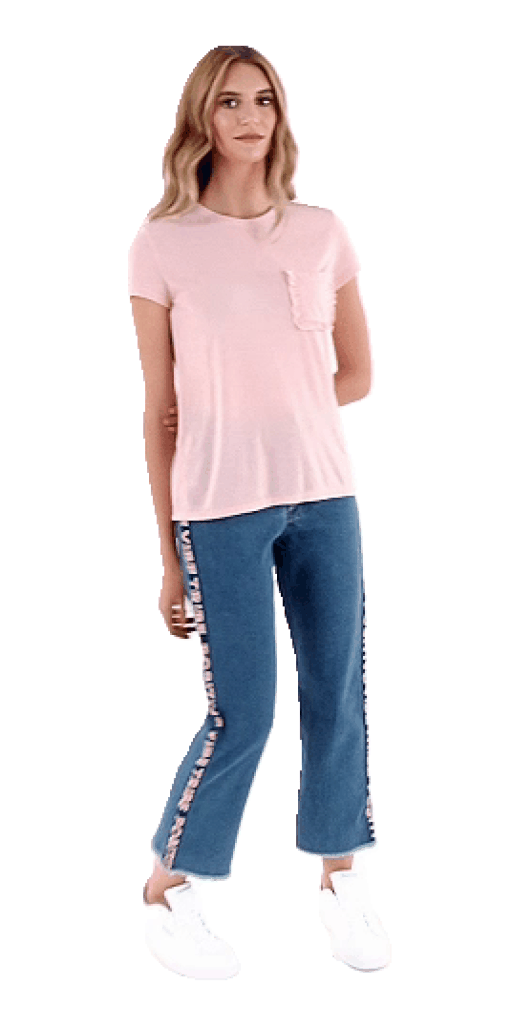

In [414]:
display_gif(f'{save_dir}/orginal.gif')

In [415]:
ts = c1.clone() / model.video_length
ts = ts - ts[0]


In [416]:
rec_1_path

'applications_results/_resume__422_fashion_w_sampling_diff_style2022-11-06T16-06-052022-11-08T00-54-58/PTI/2c112954/find_tuned_manipulalted.gif'

In [417]:
rec_1_path = f'{save_dir}/styleode_rec.gif'
with torch.no_grad():
#     dyn = model.video_dynamic_rep(a1.unsqueeze(0), c1, mask=torch.ones(a1.shape[0], 1)) 
    txt_feat_1 = model.clip_encode_text(desc1)  # - model.clip_encode_text([src_desc])

    W_c_ind = len(b1) // 3
    W_c_ind = 1
    W_c = b1[W_c_ind:W_c_ind+1]
    ref_frame = model.stylegan_G(W_c)
    ref_frame_enc =  model.clip_loss.encode_images(ref_frame)
    rec_vid_1 = model(a1.unsqueeze(0), 
                                  c1,
                                  W_c,
                                  torch.zeros_like(txt_feat_1),
                                 ref_frame_enc)[0]
    save_gif(rec_vid_1, (-1, 1), rec_1_path)

/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


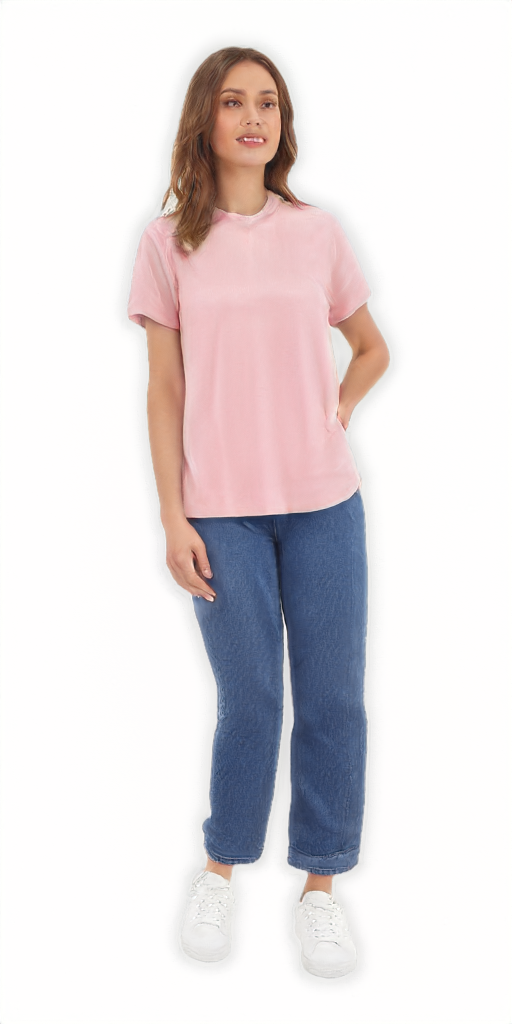

In [418]:
to_PIL(model.stylegan_G(W_c)[0])

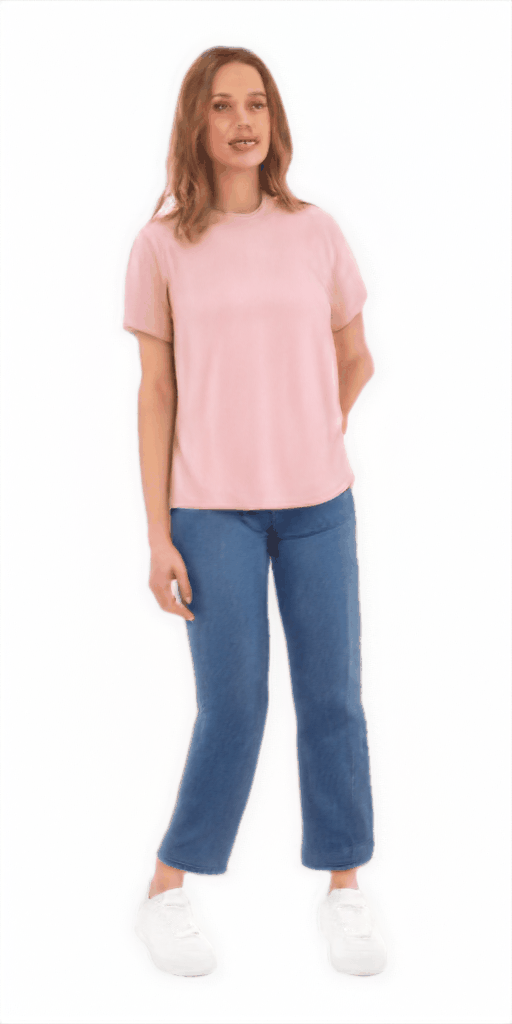

In [419]:
display_gif(rec_1_path)

# Fine Tune the generator

In [420]:
max_pti_steps = 100
pt_l2_lambda = 10.0
pt_lpips_lambda = 1.0 
lr = 3e-5
use_locality_regularization = False
locality_regularization_interval = 1

In [391]:
l2_criterion = torch.nn.MSELoss(reduction='mean')
def l2_loss(real_images, generated_images):
    loss = l2_criterion(real_images, generated_images)
    return loss


In [392]:
from lpips import LPIPS
lpips_loss = LPIPS(net='alex').to(device).eval()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [393]:
class SpaceRegularizer:
    def __init__(self, original_G, lpips_net):
        
        regularizer_alpha = 50
        self.latent_ball_num_of_samples = 1
        self.locality_regularization_interval = 1
        self.use_locality_regularization = True
        self.regularizer_l2_lambda = 0.1
        self.regularizer_lpips_lambda = 0.1
        
        
        self.original_G = original_G
        self.morphing_regularizer_alpha = regularizer_alpha
        self.lpips_loss = lpips_net
        self.regularizer_alpha = regularizer_alpha

    def get_morphed_w_code(self, new_w_code, fixed_w):
        interpolation_direction = new_w_code - fixed_w
        interpolation_direction_norm = torch.norm(interpolation_direction, p=2)
        direction_to_move = self.regularizer_alpha * interpolation_direction / interpolation_direction_norm
        result_w = fixed_w + direction_to_move
        self.morphing_regularizer_alpha * fixed_w + (1 - self.morphing_regularizer_alpha) * new_w_code

        return result_w

    def get_image_from_ws(self, w_codes, G):
        return torch.cat([G.synthesis(w_code, noise_mode='none', force_fp32=True) for w_code in w_codes])

    def ball_holder_loss_lazy(self, new_G, num_of_sampled_latents, w_batch, use_wandb=False):
        loss = 0.0

        z_samples = np.random.randn(num_of_sampled_latents, self.original_G.G.z_dim)
        w_samples = self.original_G.G.mapping(torch.from_numpy(z_samples).to(device), None,
                                            truncation_psi=0.5)
        territory_indicator_ws = [self.get_morphed_w_code(w_code.unsqueeze(0), w_batch) for w_code in w_samples]

        for w_code in territory_indicator_ws:
            new_img = new_G(w_code)
            with torch.no_grad():
                old_img = self.original_G(w_code)

            if self.regularizer_l2_lambda > 0:
                l2_loss_val = l2_loss(old_img, new_img)
                loss += l2_loss_val * self.regularizer_l2_lambda

            if self.regularizer_lpips_lambda > 0:
                loss_lpips = self.lpips_loss(old_img, new_img)
                loss_lpips = torch.mean(torch.squeeze(loss_lpips))
                loss += loss_lpips * self.regularizer_lpips_lambda

        return loss / len(territory_indicator_ws)

    def space_regularizer_loss(self, new_G, w_batch):
        ret_val = self.ball_holder_loss_lazy(new_G, self.latent_ball_num_of_samples, w_batch)
        return ret_val
    


In [394]:
def calc_loss(generated_images, real_images, new_G, use_ball_holder, w_batch):
        loss = 0.0

        if pt_l2_lambda > 0:
            l2_loss_val = l2_loss(generated_images, real_images)
            loss += l2_loss_val * pt_l2_lambda
        if pt_lpips_lambda > 0:
            loss_lpips = lpips_loss(generated_images, real_images)
            loss_lpips = torch.squeeze(loss_lpips)
            loss += loss_lpips * pt_lpips_lambda

        if use_ball_holder and use_locality_regularization:
            ball_holder_loss_val = space_regularizer.space_regularizer_loss(new_G, w_batch)
            loss += ball_holder_loss_val

        return loss, l2_loss_val, loss_lpips

# Reset

# Train

In [433]:
# model.stylegan_G.synthesis.train()
# model.stylegan_G.mapping.train()
import copy
model.stylegan_G.train()
model.stylegan_G.requires_grad_(True)
model.requires_grad(model.stylegan_G, True)
use_ball_holder = True
w_pivots = []
images = []

In [434]:
space_regularizer = SpaceRegularizer(original_G, lpips_loss)
optimizer = torch.optim.Adam(model.stylegan_G.parameters(), betas=(0.9, 0.999),
                                     lr=lr)

In [435]:
# ATTENTION: Do one. normalize images
a1 = a1 * 2 - 1
a1.shape

torch.Size([6, 3, 1024, 512])

In [447]:
from collections import defaultdict
from tqdm import tqdm
print('Fine tuning generator')
training_step = 0
pbar = tqdm(range(max_pti_steps))
for step in pbar:
    step_loss_dict = defaultdict(list)
    t = (step + 1) / max_pti_steps

    for image, w_pivot in zip(a1, b1):
        image = image.unsqueeze(0)
        w_pivot = w_pivot.unsqueeze(0)
        generated_images = model.stylegan_G(w_pivot)
        loss, l2_loss_val, loss_lpips = calc_loss(generated_images, image,
                                                       model.stylegan_G, use_ball_holder, w_pivot)
        
        print(l2_loss_val.item(), loss_lpips.item())
        step_loss_dict['loss'].append(loss.item())
        step_loss_dict['l2_loss'].append(l2_loss_val.item())
        step_loss_dict['loss_lpips'].append(loss_lpips.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        use_ball_holder = training_step % locality_regularization_interval == 0

        training_step += 1
        pbar.set_description(f"loss: {l2_loss_val.item():.2f}")

    log_dict = {}
    for key, losses in step_loss_dict.items():
        loss_mean = sum(losses) / len(losses)
        loss_max = max(losses)
        log_dict[f'losses_agg/{key}_mean'] = loss_mean
        log_dict[f'losses_agg/{key}_max'] = loss_max

print('Finished training')

Fine tuning generator


loss: 0.02:   0%|          | 0/100 [00:00<?, ?it/s]

0.01562463492155075 0.11296862363815308
0.013629108667373657 0.10747911036014557


loss: 0.01:   0%|          | 0/100 [00:00<?, ?it/s]

0.015915267169475555 0.11023059487342834
0.014643432572484016 0.10999090224504471


loss: 0.02:   1%|          | 1/100 [00:00<01:12,  1.37it/s]

0.014638170599937439 0.11239926517009735
0.017628904432058334 0.12290064990520477


loss: 0.01:   1%|          | 1/100 [00:00<01:12,  1.37it/s]

0.015567870810627937 0.11269573867321014
0.013573048636317253 0.1070823073387146


loss: 0.01:   1%|          | 1/100 [00:01<01:12,  1.37it/s]

0.015858694911003113 0.10998401045799255
0.014580811373889446 0.10966484993696213


loss: 0.02:   2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

0.014597892761230469 0.11198443174362183
0.017578978091478348 0.12254676222801208


loss: 0.01:   2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

0.015512737445533276 0.11240248382091522
0.013516726903617382 0.10664340853691101


loss: 0.01:   2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

0.015805445611476898 0.10973264276981354
0.014518540352582932 0.10934959352016449


loss: 0.02:   3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

0.014546463266015053 0.1116713359951973
0.017528846859931946 0.12217888981103897


loss: 0.01:   3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

0.015464561991393566 0.11208430677652359
0.013456213288009167 0.10624850541353226


loss: 0.01:   3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

0.015754317864775658 0.1094500869512558
0.014457276090979576 0.10901272296905518


loss: 0.02:   3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

0.014498304575681686 0.1113879531621933
0.017475616186857224 0.12170545756816864


loss: 0.01:   4%|▍         | 4/100 [00:03<01:07,  1.41it/s]

0.015410631895065308 0.11181890964508057
0.013401086442172527 0.10586051642894745


loss: 0.01:   4%|▍         | 4/100 [00:03<01:07,  1.41it/s]

0.015707967802882195 0.10915584862232208
0.0143977589905262 0.10865255445241928


loss: 0.02:   5%|▌         | 5/100 [00:03<01:07,  1.41it/s]

0.014455845579504967 0.11111874878406525
0.017422987148165703 0.12130908668041229


loss: 0.01:   5%|▌         | 5/100 [00:03<01:07,  1.41it/s]

0.015351943671703339 0.11160056293010712
0.01335064321756363 0.10548549890518188


loss: 0.01:   5%|▌         | 5/100 [00:04<01:07,  1.41it/s]

0.015659701079130173 0.10886923223733902
0.014339463785290718 0.10836037248373032


loss: 0.02:   6%|▌         | 6/100 [00:04<01:06,  1.41it/s]

0.01441266667097807 0.1108579933643341
0.017371803522109985 0.12098875641822815


loss: 0.01:   6%|▌         | 6/100 [00:04<01:06,  1.41it/s]

0.015293249860405922 0.11137416958808899
0.013306699693202972 0.10511983186006546


loss: 0.01:   6%|▌         | 6/100 [00:04<01:06,  1.41it/s]

0.015615004114806652 0.10856328904628754
0.01428317092359066 0.10809867084026337


loss: 0.02:   7%|▋         | 7/100 [00:04<01:04,  1.44it/s]

0.014372503384947777 0.11058047413825989
0.01731937937438488 0.12061367928981781


loss: 0.01:   7%|▋         | 7/100 [00:05<01:04,  1.44it/s]

0.015230915509164333 0.11113957315683365
0.013268797658383846 0.10474734008312225


loss: 0.01:   7%|▋         | 7/100 [00:05<01:04,  1.44it/s]

0.015572704374790192 0.10821984708309174
0.014227288775146008 0.10785875469446182


loss: 0.02:   8%|▊         | 8/100 [00:05<01:04,  1.43it/s]

0.014337105676531792 0.1102893203496933
0.0172677394002676 0.12027302384376526


loss: 0.01:   8%|▊         | 8/100 [00:05<01:04,  1.43it/s]

0.015167199075222015 0.11092351377010345
0.013231908902525902 0.10442764312028885


loss: 0.01:   8%|▊         | 8/100 [00:06<01:04,  1.43it/s]

0.015528783202171326 0.10793159902095795
0.014168712310492992 0.10763225704431534


loss: 0.02:   9%|▉         | 9/100 [00:06<01:03,  1.44it/s]

0.014294124208390713 0.11002279072999954
0.017216382548213005 0.11997929215431213


loss: 0.01:   9%|▉         | 9/100 [00:06<01:03,  1.44it/s]

0.015112879686057568 0.11071955412626266
0.013188609853386879 0.10413418710231781


loss: 0.01:   9%|▉         | 9/100 [00:06<01:03,  1.44it/s]

0.015485512092709541 0.10765562206506729
0.014109007082879543 0.10738415271043777


loss: 0.02:  10%|█         | 10/100 [00:07<01:03,  1.42it/s]

0.01425027847290039 0.10976032167673111
0.017166361212730408 0.11967366188764572


loss: 0.01:  10%|█         | 10/100 [00:07<01:03,  1.42it/s]

0.015062635764479637 0.11051616072654724
0.013144759461283684 0.10384440422058105


loss: 0.01:  10%|█         | 10/100 [00:07<01:03,  1.42it/s]

0.015447266399860382 0.10739219188690186
0.014050014317035675 0.10711152851581573


loss: 0.02:  11%|█         | 11/100 [00:07<01:02,  1.42it/s]

0.014207160100340843 0.10950995981693268
0.017118306830525398 0.11937697976827621


loss: 0.01:  11%|█         | 11/100 [00:07<01:02,  1.42it/s]

0.015013718977570534 0.11028915643692017
0.013096345588564873 0.10356742888689041


loss: 0.01:  11%|█         | 11/100 [00:08<01:02,  1.42it/s]

0.015405348502099514 0.10711048543453217
0.01399993896484375 0.10683076083660126


loss: 0.02:  12%|█▏        | 12/100 [00:08<01:01,  1.43it/s]

0.014168985188007355 0.10922680795192719
0.017068494111299515 0.11909870058298111


loss: 0.01:  12%|█▏        | 12/100 [00:08<01:01,  1.43it/s]

0.014963614754378796 0.11006195843219757
0.013046717271208763 0.1033346876502037


loss: 0.01:  12%|█▏        | 12/100 [00:08<01:01,  1.43it/s]

0.015359083190560341 0.10681679844856262
0.013955670408904552 0.1065787672996521


loss: 0.02:  13%|█▎        | 13/100 [00:09<00:59,  1.45it/s]

0.014123326167464256 0.1089676171541214
0.017022762447595596 0.11878156661987305


loss: 0.01:  13%|█▎        | 13/100 [00:09<00:59,  1.45it/s]

0.014911684207618237 0.10983875393867493
0.013001698069274426 0.10308761894702911


loss: 0.01:  13%|█▎        | 13/100 [00:09<00:59,  1.45it/s]

0.015311986207962036 0.10653713345527649
0.013910472393035889 0.1063351184129715


loss: 0.02:  14%|█▍        | 14/100 [00:09<00:59,  1.45it/s]

0.014086092822253704 0.1086866557598114
0.01697405055165291 0.11847998201847076


loss: 0.01:  14%|█▍        | 14/100 [00:10<00:59,  1.45it/s]

0.01486272644251585 0.1096256822347641
0.012960582971572876 0.10284276306629181


loss: 0.01:  14%|█▍        | 14/100 [00:10<00:59,  1.45it/s]

0.015263817273080349 0.10622277110815048
0.013861860148608685 0.10609399527311325


loss: 0.02:  15%|█▌        | 15/100 [00:10<00:58,  1.45it/s]

0.014050653204321861 0.10840475559234619
0.01692649908363819 0.11817432940006256


loss: 0.01:  15%|█▌        | 15/100 [00:10<00:58,  1.45it/s]

0.014813895337283611 0.10937301069498062
0.01292334869503975 0.10257332026958466


loss: 0.01:  15%|█▌        | 15/100 [00:10<00:58,  1.45it/s]

0.015220562927424908 0.10597121715545654
0.01380916964262724 0.10585329681634903


loss: 0.02:  16%|█▌        | 16/100 [00:11<00:57,  1.45it/s]

0.014006679877638817 0.10816333442926407
0.016882391646504402 0.11785057187080383


loss: 0.01:  16%|█▌        | 16/100 [00:11<00:57,  1.45it/s]

0.014766077511012554 0.10911954939365387
0.012883773073554039 0.10233332216739655


loss: 0.01:  16%|█▌        | 16/100 [00:11<00:57,  1.45it/s]

0.01517342310398817 0.10565360635519028
0.0137557964771986 0.10560646653175354


loss: 0.02:  17%|█▋        | 17/100 [00:11<00:57,  1.45it/s]

0.013970352709293365 0.10787561535835266
0.016837220638990402 0.11756844073534012


loss: 0.01:  17%|█▋        | 17/100 [00:12<00:57,  1.45it/s]

0.014717268757522106 0.10886909067630768
0.012840021401643753 0.10204063355922699


loss: 0.01:  17%|█▋        | 17/100 [00:12<00:57,  1.45it/s]

0.015130567364394665 0.10532785207033157
0.013706735335290432 0.1053619533777237


loss: 0.02:  18%|█▊        | 18/100 [00:12<00:56,  1.44it/s]

0.013932633213698864 0.10759659111499786
0.016794510185718536 0.11728136241436005


loss: 0.01:  18%|█▊        | 18/100 [00:12<00:56,  1.44it/s]

0.014666924253106117 0.10861535370349884
0.01279535423964262 0.10172264277935028


loss: 0.01:  18%|█▊        | 18/100 [00:13<00:56,  1.44it/s]

0.015087909996509552 0.10500965267419815
0.013657299801707268 0.10509470850229263


loss: 0.02:  19%|█▉        | 19/100 [00:13<00:56,  1.44it/s]

0.013894530013203621 0.10732688009738922
0.016750101000070572 0.11700350046157837


loss: 0.01:  19%|█▉        | 19/100 [00:13<00:56,  1.44it/s]

0.014615228399634361 0.1083436980843544
0.01274583488702774 0.1014159768819809


loss: 0.01:  19%|█▉        | 19/100 [00:13<00:56,  1.44it/s]

0.015041664242744446 0.10476107895374298
0.013605348765850067 0.10483995079994202


loss: 0.02:  20%|██        | 20/100 [00:13<00:54,  1.46it/s]

0.013855606317520142 0.10707554221153259
0.01670835353434086 0.11668162047863007


loss: 0.01:  20%|██        | 20/100 [00:14<00:54,  1.46it/s]

0.014564299955964088 0.10807125270366669
0.01269812136888504 0.10106686502695084


loss: 0.01:  20%|██        | 20/100 [00:14<00:54,  1.46it/s]

0.014995673671364784 0.10438335686922073
0.013556542806327343 0.10456779599189758


loss: 0.02:  21%|██        | 21/100 [00:14<00:54,  1.46it/s]

0.0138242794200778 0.10676776617765427
0.01666935160756111 0.1163773313164711


loss: 0.01:  21%|██        | 21/100 [00:14<00:54,  1.46it/s]

0.014513738453388214 0.10779683291912079
0.012643473222851753 0.10070087015628815


loss: 0.01:  21%|██        | 21/100 [00:15<00:54,  1.46it/s]

0.014950660988688469 0.10410548746585846
0.013506017625331879 0.10438260436058044


loss: 0.02:  22%|██▏       | 22/100 [00:15<00:53,  1.45it/s]

0.013778043910861015 0.10654899477958679
0.016633175313472748 0.11609723418951035


loss: 0.01:  22%|██▏       | 22/100 [00:15<00:53,  1.45it/s]

0.01446329616010189 0.10755723714828491
0.012592464685440063 0.10036124289035797


loss: 0.01:  22%|██▏       | 22/100 [00:15<00:53,  1.45it/s]

0.014906744472682476 0.10380006581544876
0.013461312279105186 0.10415472090244293


loss: 0.02:  23%|██▎       | 23/100 [00:16<00:53,  1.45it/s]

0.013751594349741936 0.10619746148586273
0.016590673476457596 0.11582877486944199


loss: 0.01:  23%|██▎       | 23/100 [00:16<00:53,  1.45it/s]

0.01441066712141037 0.10732530057430267
0.012546434067189693 0.09999539703130722


loss: 0.01:  23%|██▎       | 23/100 [00:16<00:53,  1.45it/s]

0.014862827025353909 0.10351832956075668
0.013417376205325127 0.10392915457487106


loss: 0.02:  24%|██▍       | 24/100 [00:16<00:53,  1.43it/s]

0.01371602900326252 0.10593298077583313
0.016550257802009583 0.11556337028741837


loss: 0.01:  24%|██▍       | 24/100 [00:16<00:53,  1.43it/s]

0.014359528198838234 0.1070885881781578
0.012497976422309875 0.0996508002281189


loss: 0.01:  24%|██▍       | 24/100 [00:17<00:53,  1.43it/s]

0.0148165849968791 0.10320992022752762
0.013375378213822842 0.103688545525074


loss: 0.02:  25%|██▌       | 25/100 [00:17<00:52,  1.43it/s]

0.013689721003174782 0.10562794655561447
0.016504187136888504 0.11533204466104507


loss: 0.01:  25%|██▌       | 25/100 [00:17<00:52,  1.43it/s]

0.0143130486831069 0.10682237148284912
0.012444919906556606 0.09928521513938904


loss: 0.01:  25%|██▌       | 25/100 [00:17<00:52,  1.43it/s]

0.014770783483982086 0.1029144898056984
0.01332894992083311 0.10348916798830032


loss: 0.02:  26%|██▌       | 26/100 [00:18<00:52,  1.42it/s]

0.013649975880980492 0.10539393126964569
0.016465414315462112 0.11503837257623672


loss: 0.01:  26%|██▌       | 26/100 [00:18<00:52,  1.42it/s]

0.01426992379128933 0.10656967759132385
0.012388788163661957 0.09892769157886505


loss: 0.01:  26%|██▌       | 26/100 [00:18<00:52,  1.42it/s]

0.014724335633218288 0.10260505229234695
0.013282999396324158 0.1032462790608406


loss: 0.02:  27%|██▋       | 27/100 [00:18<00:51,  1.42it/s]

0.01362153422087431 0.10509441047906876
0.016422158107161522 0.11477374285459518


loss: 0.01:  27%|██▋       | 27/100 [00:19<00:51,  1.42it/s]

0.014225284568965435 0.10628080368041992
0.012335507199168205 0.09854914247989655


loss: 0.01:  27%|██▋       | 27/100 [00:19<00:51,  1.42it/s]

0.014682849869132042 0.10234405100345612
0.013238610699772835 0.10298977792263031


loss: 0.02:  28%|██▊       | 28/100 [00:19<00:50,  1.43it/s]

0.013583846390247345 0.10482984036207199
0.01637951470911503 0.11452090740203857


loss: 0.01:  28%|██▊       | 28/100 [00:19<00:50,  1.43it/s]

0.014182409271597862 0.10599277168512344
0.012278225272893906 0.09820310771465302


loss: 0.01:  28%|██▊       | 28/100 [00:19<00:50,  1.43it/s]

0.014637946151196957 0.10201548784971237
0.013194809667766094 0.10273095965385437


loss: 0.02:  29%|██▉       | 29/100 [00:20<00:49,  1.44it/s]

0.01354660652577877 0.10455016791820526
0.016336902976036072 0.11425997316837311


loss: 0.01:  29%|██▉       | 29/100 [00:20<00:49,  1.44it/s]

0.014138391241431236 0.10573404282331467
0.01222605537623167 0.0978601947426796


loss: 0.01:  29%|██▉       | 29/100 [00:20<00:49,  1.44it/s]

0.014594076201319695 0.10171877592802048
0.01315162144601345 0.10247045755386353


loss: 0.02:  30%|███       | 30/100 [00:20<00:48,  1.45it/s]

0.013506813906133175 0.10429350286722183
0.016293950378894806 0.11400261521339417


loss: 0.01:  30%|███       | 30/100 [00:21<00:48,  1.45it/s]

0.01409437507390976 0.10552103817462921
0.012170396745204926 0.09755494445562363


loss: 0.01:  30%|███       | 30/100 [00:21<00:48,  1.45it/s]

0.014549042098224163 0.10144628584384918
0.013109305873513222 0.10217644274234772


loss: 0.02:  31%|███       | 31/100 [00:21<00:47,  1.45it/s]

0.013472413644194603 0.10400936752557755
0.016251301392912865 0.11378215998411179


loss: 0.01:  31%|███       | 31/100 [00:21<00:47,  1.45it/s]

0.014049515128135681 0.10532420873641968
0.012120775878429413 0.0972430557012558


loss: 0.01:  31%|███       | 31/100 [00:22<00:47,  1.45it/s]

0.014502792619168758 0.10121428966522217
0.01306829135864973 0.10188247263431549


loss: 0.02:  32%|███▏      | 32/100 [00:22<00:46,  1.46it/s]

0.01344056986272335 0.10369451344013214
0.016208000481128693 0.1135723888874054


loss: 0.01:  32%|███▏      | 32/100 [00:22<00:46,  1.46it/s]

0.014008387923240662 0.1051042303442955
0.012072497978806496 0.09702660143375397


loss: 0.01:  32%|███▏      | 32/100 [00:22<00:46,  1.46it/s]

0.014453984797000885 0.10094979405403137
0.013028952293097973 0.10159192979335785


loss: 0.02:  33%|███▎      | 33/100 [00:22<00:45,  1.46it/s]

0.01340503990650177 0.10340939462184906
0.01616757921874523 0.113312266767025


loss: 0.01:  33%|███▎      | 33/100 [00:23<00:45,  1.46it/s]

0.013964290730655193 0.10493969917297363
0.012027045711874962 0.09675661474466324


loss: 0.01:  33%|███▎      | 33/100 [00:23<00:45,  1.46it/s]

0.014416366815567017 0.10072889178991318
0.012984653934836388 0.10135124623775482


loss: 0.02:  34%|███▍      | 34/100 [00:23<00:45,  1.44it/s]

0.013367260806262493 0.1031423807144165
0.016123156994581223 0.11305619031190872


loss: 0.01:  34%|███▍      | 34/100 [00:23<00:45,  1.44it/s]

0.013920215889811516 0.10475047677755356
0.011979296803474426 0.09656307101249695


loss: 0.01:  34%|███▍      | 34/100 [00:24<00:45,  1.44it/s]

0.014375215396285057 0.10045179724693298
0.012950360774993896 0.10110414773225784


loss: 0.02:  35%|███▌      | 35/100 [00:24<00:45,  1.43it/s]

0.013335756957530975 0.10286896675825119
0.016074374318122864 0.11284685134887695


loss: 0.01:  35%|███▌      | 35/100 [00:24<00:45,  1.43it/s]

0.013871538452804089 0.10457062721252441
0.011932059191167355 0.09633390605449677


loss: 0.01:  35%|███▌      | 35/100 [00:24<00:45,  1.43it/s]

0.014335189014673233 0.10019408166408539
0.012914177030324936 0.10086078941822052


loss: 0.02:  36%|███▌      | 36/100 [00:25<00:44,  1.43it/s]

0.01330578699707985 0.10259337723255157
0.016026971861720085 0.11259596794843674


loss: 0.01:  36%|███▌      | 36/100 [00:25<00:44,  1.43it/s]

0.013830072246491909 0.10436080396175385
0.011880600824952126 0.09605090320110321


loss: 0.01:  36%|███▌      | 36/100 [00:25<00:44,  1.43it/s]

0.014296598732471466 0.09991291165351868
0.012882951647043228 0.10061177611351013


loss: 0.02:  37%|███▋      | 37/100 [00:25<00:43,  1.44it/s]

0.013267286121845245 0.1023685485124588
0.015985911712050438 0.11234909296035767


loss: 0.01:  37%|███▋      | 37/100 [00:25<00:43,  1.44it/s]

0.013782582245767117 0.10415453463792801
0.011829002760350704 0.0958162248134613


loss: 0.01:  37%|███▋      | 37/100 [00:26<00:43,  1.44it/s]

0.014258146286010742 0.09967586398124695
0.012851356528699398 0.1003631129860878


loss: 0.02:  38%|███▊      | 38/100 [00:26<00:43,  1.44it/s]

0.013232196681201458 0.10214972496032715
0.015942854806780815 0.11214325577020645


loss: 0.01:  38%|███▊      | 38/100 [00:26<00:43,  1.44it/s]

0.013733720406889915 0.10393333435058594
0.011777376756072044 0.09550950676202774


loss: 0.01:  38%|███▊      | 38/100 [00:26<00:43,  1.44it/s]

0.01421608030796051 0.09941278398036957
0.012823144905269146 0.10009973496198654


loss: 0.02:  39%|███▉      | 39/100 [00:27<00:42,  1.44it/s]

0.013206005096435547 0.10192490369081497
0.015900449827313423 0.11194504797458649


loss: 0.01:  39%|███▉      | 39/100 [00:27<00:42,  1.44it/s]

0.013679474592208862 0.10372522473335266
0.011727964505553246 0.0951666384935379


loss: 0.01:  39%|███▉      | 39/100 [00:27<00:42,  1.44it/s]

0.014175526797771454 0.09917494654655457
0.012797361239790916 0.09985342621803284


loss: 0.02:  40%|████      | 40/100 [00:27<00:41,  1.45it/s]

0.013168973848223686 0.10174617916345596
0.01586185023188591 0.1117321252822876


loss: 0.01:  40%|████      | 40/100 [00:28<00:41,  1.45it/s]

0.013627288863062859 0.10348012298345566
0.011677835136651993 0.094890296459198


loss: 0.01:  40%|████      | 40/100 [00:28<00:41,  1.45it/s]

0.014137323014438152 0.09890606254339218
0.012774414382874966 0.09959866106510162


loss: 0.01:  40%|████      | 40/100 [00:28<00:41,  1.45it/s]

0.013138903304934502 0.10154034197330475
0.015820469707250595 0.11153693497180939


loss: 0.01:  41%|████      | 41/100 [00:28<00:40,  1.45it/s]

0.013580366969108582 0.10320568084716797
0.011621730402112007 0.09461648762226105


loss: 0.01:  41%|████      | 41/100 [00:28<00:40,  1.45it/s]

0.01410395186394453 0.09865300357341766
0.012748267501592636 0.09938796609640121


loss: 0.02:  42%|████▏     | 42/100 [00:29<00:40,  1.44it/s]

0.013105730526149273 0.10134074836969376
0.015781177207827568 0.11134104430675507


loss: 0.01:  42%|████▏     | 42/100 [00:29<00:40,  1.44it/s]

0.013535376638174057 0.10295911133289337
0.01157144084572792 0.09433935582637787


loss: 0.01:  42%|████▏     | 42/100 [00:29<00:40,  1.44it/s]

0.014071917161345482 0.09842801839113235
0.01271803304553032 0.09919168800115585


loss: 0.02:  43%|████▎     | 43/100 [00:29<00:39,  1.45it/s]

0.013077152892947197 0.10110681504011154
0.015739381313323975 0.11114354431629181


loss: 0.01:  43%|████▎     | 43/100 [00:30<00:39,  1.45it/s]

0.013491854071617126 0.10270048677921295
0.01152508519589901 0.0940876230597496


loss: 0.01:  43%|████▎     | 43/100 [00:30<00:39,  1.45it/s]

0.014039169996976852 0.09821045398712158
0.012688463553786278 0.09897877275943756


loss: 0.02:  44%|████▍     | 44/100 [00:30<00:38,  1.45it/s]

0.013041920959949493 0.10088452696800232
0.015701156109571457 0.1109127402305603


loss: 0.01:  44%|████▍     | 44/100 [00:30<00:38,  1.45it/s]

0.013451649807393551 0.1024717390537262
0.011484014801681042 0.09386024624109268


loss: 0.01:  44%|████▍     | 44/100 [00:31<00:38,  1.45it/s]

0.014004146680235863 0.09800030291080475
0.012658616527915001 0.09874063730239868


loss: 0.02:  45%|████▌     | 45/100 [00:31<00:37,  1.45it/s]

0.01300685666501522 0.10066407918930054
0.01566047966480255 0.11069832742214203


loss: 0.01:  45%|████▌     | 45/100 [00:31<00:37,  1.45it/s]

0.01341284066438675 0.10225111246109009
0.01144771184772253 0.09364453703165054


loss: 0.01:  45%|████▌     | 45/100 [00:31<00:37,  1.45it/s]

0.013970784842967987 0.09778497368097305
0.012628371827304363 0.09848786890506744
0.012975960969924927 0.10043694823980331


loss: 0.01:  46%|████▌     | 46/100 [00:31<00:35,  1.50it/s]

0.015616275370121002 0.11049526184797287
0.013375980779528618 0.10205350071191788


loss: 0.01:  46%|████▌     | 46/100 [00:32<00:35,  1.50it/s]

0.011411826126277447 0.09347088634967804
0.013935303315520287 0.09755408018827438


loss: 0.01:  46%|████▌     | 46/100 [00:32<00:35,  1.50it/s]

0.012597763910889626 0.09821902960538864
0.01294619869440794 0.10019522905349731


loss: 0.01:  47%|████▋     | 47/100 [00:32<00:36,  1.47it/s]

0.015572164207696915 0.11028796434402466
0.013340800069272518 0.1018436923623085


loss: 0.01:  47%|████▋     | 47/100 [00:32<00:36,  1.47it/s]

0.011379413306713104 0.0933176577091217
0.013900034129619598 0.09730099141597748


loss: 0.01:  47%|████▋     | 47/100 [00:33<00:36,  1.47it/s]

0.012568000704050064 0.09792765974998474
0.012914573773741722 0.0999627634882927


loss: 0.01:  48%|████▊     | 48/100 [00:33<00:35,  1.45it/s]

0.015528189018368721 0.11008229851722717
0.013309082947671413 0.10164889693260193


loss: 0.01:  48%|████▊     | 48/100 [00:33<00:35,  1.45it/s]

0.011346673592925072 0.0931280255317688
0.013866353780031204 0.0970400720834732


loss: 0.01:  48%|████▊     | 48/100 [00:33<00:35,  1.45it/s]

0.012532907538115978 0.09764459729194641
0.012888132594525814 0.09969975799322128


loss: 0.01:  49%|████▉     | 49/100 [00:34<00:35,  1.45it/s]

0.015484333038330078 0.10986443608999252
0.013280263170599937 0.10143876075744629


loss: 0.01:  49%|████▉     | 49/100 [00:34<00:35,  1.45it/s]

0.01131388358771801 0.09290558099746704
0.01383468508720398 0.09679894894361496


loss: 0.01:  49%|████▉     | 49/100 [00:34<00:35,  1.45it/s]

0.012501011602580547 0.09740245342254639
0.012857725843787193 0.0994693711400032


loss: 0.01:  50%|█████     | 50/100 [00:34<00:34,  1.44it/s]

0.015443004667758942 0.10966840386390686
0.013250967487692833 0.10122476518154144


loss: 0.01:  50%|█████     | 50/100 [00:35<00:34,  1.44it/s]

0.011281339451670647 0.09270957112312317
0.013799021951854229 0.09652332216501236


loss: 0.01:  50%|█████     | 50/100 [00:35<00:34,  1.44it/s]

0.012476084753870964 0.0971234068274498
0.01282975822687149 0.09924283623695374


loss: 0.01:  51%|█████     | 51/100 [00:35<00:34,  1.43it/s]

0.015399418771266937 0.10948450863361359
0.013219784945249557 0.10103228688240051


loss: 0.01:  51%|█████     | 51/100 [00:35<00:34,  1.43it/s]

0.011248121969401836 0.09251628071069717
0.013762220740318298 0.0962819904088974


loss: 0.01:  51%|█████     | 51/100 [00:35<00:34,  1.43it/s]

0.01245364360511303 0.09686267375946045
0.012797615490853786 0.09904803335666656


loss: 0.01:  52%|█████▏    | 52/100 [00:36<00:33,  1.44it/s]

0.015358156524598598 0.10930953919887543
0.01318861823529005 0.10085473954677582


loss: 0.01:  52%|█████▏    | 52/100 [00:36<00:33,  1.44it/s]

0.011207769624888897 0.09230112284421921
0.013730466365814209 0.09605204313993454


loss: 0.01:  52%|█████▏    | 52/100 [00:36<00:33,  1.44it/s]

0.012428997084498405 0.09664095938205719
0.012770801782608032 0.09886208176612854


loss: 0.01:  53%|█████▎    | 53/100 [00:36<00:32,  1.43it/s]

0.015316004864871502 0.10912056267261505
0.01315503939986229 0.10068885236978531


loss: 0.01:  53%|█████▎    | 53/100 [00:37<00:32,  1.43it/s]

0.011172652244567871 0.09206674247980118
0.013698040507733822 0.09583332389593124


loss: 0.01:  53%|█████▎    | 53/100 [00:37<00:32,  1.43it/s]

0.012400850653648376 0.09644411504268646
0.012742502614855766 0.09870344400405884


loss: 0.01:  54%|█████▍    | 54/100 [00:37<00:32,  1.43it/s]

0.01527682226151228 0.10890533030033112
0.013118855655193329 0.10052545368671417


loss: 0.01:  54%|█████▍    | 54/100 [00:37<00:32,  1.43it/s]

0.011137298308312893 0.0918252021074295
0.01366240344941616 0.09559585899114609


loss: 0.01:  54%|█████▍    | 54/100 [00:38<00:32,  1.43it/s]

0.012377622537314892 0.09625351428985596
0.012710237875580788 0.09854263812303543


loss: 0.01:  55%|█████▌    | 55/100 [00:38<00:31,  1.44it/s]

0.015236947685480118 0.10872627049684525
0.013084687292575836 0.10033881664276123


loss: 0.01:  55%|█████▌    | 55/100 [00:38<00:31,  1.44it/s]

0.011095228604972363 0.09161148220300674
0.01362608652561903 0.09535637497901917


loss: 0.01:  55%|█████▌    | 55/100 [00:38<00:31,  1.44it/s]

0.012354344129562378 0.09605510532855988
0.012681080028414726 0.09836181253194809


loss: 0.01:  56%|█████▌    | 56/100 [00:38<00:30,  1.44it/s]

0.015196477994322777 0.1085389107465744
0.013052726164460182 0.10009521245956421


loss: 0.01:  56%|█████▌    | 56/100 [00:39<00:30,  1.44it/s]

0.011053716763854027 0.0913451537489891
0.013596768490970135 0.09514585137367249


loss: 0.01:  56%|█████▌    | 56/100 [00:39<00:30,  1.44it/s]

0.012328548356890678 0.0958896279335022
0.012646356597542763 0.0981859564781189


loss: 0.01:  57%|█████▋    | 57/100 [00:39<00:29,  1.45it/s]

0.015157132409512997 0.10835228860378265
0.013020023703575134 0.09988712519407272


loss: 0.01:  57%|█████▋    | 57/100 [00:39<00:29,  1.45it/s]

0.01101326197385788 0.09111330658197403
0.013567594811320305 0.09490583091974258


loss: 0.01:  57%|█████▋    | 57/100 [00:40<00:29,  1.45it/s]

0.012300333939492702 0.09569144248962402
0.012618283741176128 0.09796486049890518


loss: 0.01:  58%|█████▊    | 58/100 [00:40<00:28,  1.46it/s]

0.015114840120077133 0.10817240178585052
0.012986983172595501 0.09970852732658386


loss: 0.01:  58%|█████▊    | 58/100 [00:40<00:28,  1.46it/s]

0.010976316407322884 0.09086138010025024
0.013541005551815033 0.09469733387231827


loss: 0.01:  58%|█████▊    | 58/100 [00:40<00:28,  1.46it/s]

0.012267887592315674 0.09548646956682205
0.012585004791617393 0.09778030216693878


loss: 0.01:  59%|█████▉    | 59/100 [00:41<00:28,  1.46it/s]

0.015079652890563011 0.1079530268907547
0.012953339144587517 0.09953230619430542


loss: 0.01:  59%|█████▉    | 59/100 [00:41<00:28,  1.46it/s]

0.010938002727925777 0.09060098230838776
0.013510052114725113 0.0944882333278656


loss: 0.01:  59%|█████▉    | 59/100 [00:41<00:28,  1.46it/s]

0.012240192852914333 0.09526033699512482
0.012559584341943264 0.09755483269691467


loss: 0.01:  60%|██████    | 60/100 [00:41<00:27,  1.46it/s]

0.015038173645734787 0.10781343281269073
0.012919200584292412 0.09935253858566284


loss: 0.01:  60%|██████    | 60/100 [00:41<00:27,  1.46it/s]

0.010898802429437637 0.0903002917766571
0.01347961276769638 0.09428796172142029


loss: 0.01:  60%|██████    | 60/100 [00:42<00:27,  1.46it/s]

0.01221047155559063 0.09504617750644684
0.012527829967439175 0.0973753035068512


loss: 0.01:  61%|██████    | 61/100 [00:42<00:26,  1.46it/s]

0.01500025950372219 0.10766613483428955
0.012885808013379574 0.09916415810585022


loss: 0.01:  61%|██████    | 61/100 [00:42<00:26,  1.46it/s]

0.010857736691832542 0.0899985060095787
0.013447284698486328 0.09410838782787323


loss: 0.01:  61%|██████    | 61/100 [00:42<00:26,  1.46it/s]

0.012183135375380516 0.09487368166446686
0.012497025541961193 0.09720141440629959


loss: 0.01:  62%|██████▏   | 62/100 [00:43<00:26,  1.45it/s]

0.014958619140088558 0.10748700052499771
0.012853915803134441 0.09897284209728241


loss: 0.01:  62%|██████▏   | 62/100 [00:43<00:26,  1.45it/s]

0.010817447677254677 0.08975569158792496
0.013414204120635986 0.09392929077148438


loss: 0.01:  62%|██████▏   | 62/100 [00:43<00:26,  1.45it/s]

0.01215510256588459 0.09469398856163025
0.012467335909605026 0.09701140224933624


loss: 0.01:  63%|██████▎   | 63/100 [00:43<00:25,  1.45it/s]

0.01491481065750122 0.10727743059396744
0.012820030562579632 0.09878667443990707


loss: 0.01:  63%|██████▎   | 63/100 [00:44<00:25,  1.45it/s]

0.010787047445774078 0.08948343992233276
0.013385605067014694 0.0937606543302536


loss: 0.01:  63%|██████▎   | 63/100 [00:44<00:25,  1.45it/s]

0.012125900946557522 0.09453007578849792
0.012426609173417091 0.0968349352478981


loss: 0.01:  64%|██████▍   | 64/100 [00:44<00:24,  1.45it/s]

0.014873338863253593 0.10705910623073578
0.01278585847467184 0.09859791398048401


loss: 0.01:  64%|██████▍   | 64/100 [00:44<00:24,  1.45it/s]

0.01075675617903471 0.08923870325088501
0.013357940129935741 0.09357321262359619


loss: 0.01:  64%|██████▍   | 64/100 [00:44<00:24,  1.45it/s]

0.012100983411073685 0.09435656666755676
0.012393350712954998 0.09663736820220947


loss: 0.01:  65%|██████▌   | 65/100 [00:45<00:23,  1.46it/s]

0.01482607051730156 0.10684628784656525
0.012753929011523724 0.0984131246805191


loss: 0.01:  65%|██████▌   | 65/100 [00:45<00:23,  1.46it/s]

0.010721194557845592 0.0890398919582367
0.01332554779946804 0.09335780143737793


loss: 0.01:  65%|██████▌   | 65/100 [00:45<00:23,  1.46it/s]

0.012081733904778957 0.09418261051177979
0.012364212423563004 0.09645070135593414


loss: 0.01:  66%|██████▌   | 66/100 [00:45<00:23,  1.45it/s]

0.014778814278542995 0.10663110017776489
0.012718508951365948 0.09823097288608551


loss: 0.01:  66%|██████▌   | 66/100 [00:46<00:23,  1.45it/s]

0.010688992217183113 0.088851198554039
0.01329118013381958 0.09312469512224197


loss: 0.01:  66%|██████▌   | 66/100 [00:46<00:23,  1.45it/s]

0.012063499540090561 0.09400727599859238
0.012334640137851238 0.09626958519220352


loss: 0.01:  67%|██████▋   | 67/100 [00:46<00:22,  1.44it/s]

0.014730285853147507 0.10641863942146301
0.012685309164226055 0.09804939478635788


loss: 0.01:  67%|██████▋   | 67/100 [00:46<00:22,  1.44it/s]

0.010654240846633911 0.08863724023103714
0.01325872540473938 0.09289335459470749


loss: 0.01:  67%|██████▋   | 67/100 [00:47<00:22,  1.44it/s]

0.012042742222547531 0.09382878243923187
0.012304509989917278 0.09610743820667267


loss: 0.01:  68%|██████▊   | 68/100 [00:47<00:22,  1.44it/s]

0.014686577022075653 0.10621321201324463
0.01265260111540556 0.09788662195205688


loss: 0.01:  68%|██████▊   | 68/100 [00:47<00:22,  1.44it/s]

0.010620894841849804 0.0884065181016922
0.013229316100478172 0.09267941862344742


loss: 0.01:  68%|██████▊   | 68/100 [00:47<00:22,  1.44it/s]

0.012018697336316109 0.09365492314100266
0.012274092994630337 0.09592379629611969


loss: 0.01:  69%|██████▉   | 69/100 [00:47<00:21,  1.45it/s]

0.01464297529309988 0.10602965950965881
0.012622058391571045 0.09773609042167664


loss: 0.01:  69%|██████▉   | 69/100 [00:48<00:21,  1.45it/s]

0.010583079420030117 0.08819928765296936
0.013198125176131725 0.09248943626880646


loss: 0.01:  69%|██████▉   | 69/100 [00:48<00:21,  1.45it/s]

0.011997587978839874 0.09349235147237778
0.012237031012773514 0.09574949741363525


loss: 0.01:  70%|███████   | 70/100 [00:48<00:20,  1.45it/s]

0.014603700488805771 0.10583750903606415
0.012588730081915855 0.09758070111274719


loss: 0.01:  70%|███████   | 70/100 [00:48<00:20,  1.45it/s]

0.010549246333539486 0.08799532800912857
0.013167964294552803 0.09231466799974442


loss: 0.01:  70%|███████   | 70/100 [00:49<00:20,  1.45it/s]

0.011973552405834198 0.09333529323339462
0.012211544439196587 0.0955485999584198


loss: 0.01:  71%|███████   | 71/100 [00:49<00:19,  1.45it/s]

0.01456104964017868 0.10565993934869766
0.012561215087771416 0.09744583070278168


loss: 0.01:  71%|███████   | 71/100 [00:49<00:19,  1.45it/s]

0.010512901470065117 0.08776634931564331
0.013141843490302563 0.09212987124919891


loss: 0.01:  71%|███████   | 71/100 [00:49<00:19,  1.45it/s]

0.011944985017180443 0.09318968653678894
0.012175980024039745 0.09538325667381287


loss: 0.01:  72%|███████▏  | 72/100 [00:49<00:19,  1.46it/s]

0.01452772505581379 0.10544579476118088
0.012526924721896648 0.09724488854408264


loss: 0.01:  72%|███████▏  | 72/100 [00:50<00:19,  1.46it/s]

0.010475936345756054 0.08762867748737335
0.013110022060573101 0.09194501489400864


loss: 0.01:  72%|███████▏  | 72/100 [00:50<00:19,  1.46it/s]

0.011919243261218071 0.09302014857530594
0.012153631076216698 0.09518823027610779


loss: 0.01:  73%|███████▎  | 73/100 [00:50<00:18,  1.46it/s]

0.014489036053419113 0.10523867607116699
0.012494909577071667 0.09706367552280426


loss: 0.01:  73%|███████▎  | 73/100 [00:50<00:18,  1.46it/s]

0.010443384759128094 0.08744845539331436
0.01308099552989006 0.09178643673658371


loss: 0.01:  73%|███████▎  | 73/100 [00:51<00:18,  1.46it/s]

0.011888362467288971 0.09283719211816788
0.012126731686294079 0.09497657418251038


loss: 0.01:  74%|███████▍  | 74/100 [00:51<00:17,  1.46it/s]

0.014453386887907982 0.10503572225570679
0.012464627623558044 0.09686274826526642


loss: 0.01:  74%|███████▍  | 74/100 [00:51<00:17,  1.46it/s]

0.010400492697954178 0.08724495023488998
0.013051597401499748 0.09160204231739044


loss: 0.01:  74%|███████▍  | 74/100 [00:51<00:17,  1.46it/s]

0.011863093823194504 0.09268142282962799
0.012100229039788246 0.09477322548627853


loss: 0.01:  75%|███████▌  | 75/100 [00:52<00:17,  1.45it/s]

0.014415661804378033 0.10484093427658081
0.01242959126830101 0.09673056751489639


loss: 0.01:  75%|███████▌  | 75/100 [00:52<00:17,  1.45it/s]

0.010362721048295498 0.08705584704875946
0.013017624616622925 0.09139940142631531


loss: 0.01:  75%|███████▌  | 75/100 [00:52<00:17,  1.45it/s]

0.011837685480713844 0.09251669049263
0.012076243758201599 0.09454846382141113


loss: 0.01:  76%|███████▌  | 76/100 [00:52<00:16,  1.43it/s]

0.014377346262335777 0.10464828461408615
0.0123981898650527 0.09658422321081161


loss: 0.01:  76%|███████▌  | 76/100 [00:52<00:16,  1.43it/s]

0.010323124937713146 0.08686010539531708
0.012988744303584099 0.09121710062026978


loss: 0.01:  76%|███████▌  | 76/100 [00:53<00:16,  1.43it/s]

0.011810585856437683 0.09236288070678711
0.012044750154018402 0.09436993300914764


loss: 0.01:  77%|███████▋  | 77/100 [00:53<00:16,  1.44it/s]

0.01434139534831047 0.10445290058851242
0.012366782873868942 0.09641041606664658


loss: 0.01:  77%|███████▋  | 77/100 [00:53<00:16,  1.44it/s]

0.010286994278430939 0.08672498166561127
0.012953389436006546 0.09102976322174072


loss: 0.01:  77%|███████▋  | 77/100 [00:53<00:16,  1.44it/s]

0.011786377988755703 0.09220123291015625
0.012021067552268505 0.09419243037700653


loss: 0.01:  78%|███████▊  | 78/100 [00:54<00:15,  1.45it/s]

0.01430331077426672 0.10424482077360153
0.01233676727861166 0.09627649933099747


loss: 0.01:  78%|███████▊  | 78/100 [00:54<00:15,  1.45it/s]

0.010256897658109665 0.08657921850681305
0.012923041358590126 0.09083597362041473


loss: 0.01:  78%|███████▊  | 78/100 [00:54<00:15,  1.45it/s]

0.011759985238313675 0.09204524755477905
0.011994101107120514 0.09404689073562622


loss: 0.01:  79%|███████▉  | 79/100 [00:54<00:14,  1.45it/s]

0.01426810584962368 0.10402566194534302
0.012310849502682686 0.09613285213708878


loss: 0.01:  79%|███████▉  | 79/100 [00:55<00:14,  1.45it/s]

0.010221998207271099 0.08646576851606369
0.012894093990325928 0.09063377976417542


loss: 0.01:  79%|███████▉  | 79/100 [00:55<00:14,  1.45it/s]

0.011733676306903362 0.09186708182096481
0.011972139589488506 0.09391441196203232


loss: 0.01:  80%|████████  | 80/100 [00:55<00:13,  1.45it/s]

0.014231255277991295 0.10382218658924103
0.012283777818083763 0.0959891676902771


loss: 0.01:  80%|████████  | 80/100 [00:55<00:13,  1.45it/s]

0.010191967710852623 0.08632204681634903
0.012869743630290031 0.09044913947582245


loss: 0.01:  80%|████████  | 80/100 [00:55<00:13,  1.45it/s]

0.011704972945153713 0.09167846292257309
0.011943536810576916 0.09379371255636215


loss: 0.01:  81%|████████  | 81/100 [00:56<00:13,  1.45it/s]

0.01419895887374878 0.10361002385616302
0.012256883084774017 0.09585674107074738


loss: 0.01:  81%|████████  | 81/100 [00:56<00:13,  1.45it/s]

0.010165411978960037 0.086160808801651
0.01284012757241726 0.09023449569940567


loss: 0.01:  81%|████████  | 81/100 [00:56<00:13,  1.45it/s]

0.011680962517857552 0.09148811548948288
0.011919770389795303 0.09365218132734299


loss: 0.01:  82%|████████▏ | 82/100 [00:56<00:12,  1.46it/s]

0.01416278537362814 0.1034325510263443
0.01223045215010643 0.09572932124137878


loss: 0.01:  82%|████████▏ | 82/100 [00:57<00:12,  1.46it/s]

0.01013905368745327 0.08600405603647232
0.012813104316592216 0.09003259241580963


loss: 0.01:  82%|████████▏ | 82/100 [00:57<00:12,  1.46it/s]

0.011655481532216072 0.09131324291229248
0.01189199648797512 0.09350825101137161


loss: 0.01:  83%|████████▎ | 83/100 [00:57<00:11,  1.47it/s]

0.014129811897873878 0.1032341793179512
0.01220494881272316 0.09558920562267303


loss: 0.01:  83%|████████▎ | 83/100 [00:57<00:11,  1.47it/s]

0.010114858858287334 0.08584688603878021
0.012780912220478058 0.0898427665233612


loss: 0.01:  83%|████████▎ | 83/100 [00:58<00:11,  1.47it/s]

0.011635932140052319 0.0911351889371872
0.011870240792632103 0.09336091578006744


loss: 0.01:  84%|████████▍ | 84/100 [00:58<00:10,  1.46it/s]

0.014092622324824333 0.10303875803947449
0.012178114615380764 0.09545376896858215


loss: 0.01:  84%|████████▍ | 84/100 [00:58<00:10,  1.46it/s]

0.010089259594678879 0.08568514883518219
0.01274898275732994 0.08964071422815323


loss: 0.01:  84%|████████▍ | 84/100 [00:58<00:10,  1.46it/s]

0.011617559939622879 0.09096428751945496
0.011850624345242977 0.09318272024393082


loss: 0.01:  85%|████████▌ | 85/100 [00:58<00:10,  1.46it/s]

0.014059829525649548 0.10283222049474716
0.012150278314948082 0.09531662613153458


loss: 0.01:  85%|████████▌ | 85/100 [00:59<00:10,  1.46it/s]

0.010061117820441723 0.08549375832080841
0.012723448686301708 0.08946241438388824


loss: 0.01:  85%|████████▌ | 85/100 [00:59<00:10,  1.46it/s]

0.01159827783703804 0.09079609811306
0.011825735680758953 0.09303057193756104


loss: 0.01:  86%|████████▌ | 86/100 [00:59<00:09,  1.46it/s]

0.01402699388563633 0.10264068841934204
0.012121494859457016 0.09518598765134811


loss: 0.01:  86%|████████▌ | 86/100 [00:59<00:09,  1.46it/s]

0.010025390423834324 0.08533965796232224
0.012698529288172722 0.08930046856403351


loss: 0.01:  86%|████████▌ | 86/100 [01:00<00:09,  1.46it/s]

0.011579437181353569 0.09064837545156479
0.011801349930465221 0.09287334978580475


loss: 0.01:  87%|████████▋ | 87/100 [01:00<00:08,  1.45it/s]

0.013992819003760815 0.10246694087982178
0.012090745382010937 0.09504972398281097


loss: 0.01:  87%|████████▋ | 87/100 [01:00<00:08,  1.45it/s]

0.009995725937187672 0.08517728745937347
0.0126731488853693 0.08913217484951019


loss: 0.01:  87%|████████▋ | 87/100 [01:00<00:08,  1.45it/s]

0.011559861712157726 0.09049652516841888
0.011775709688663483 0.09273861348628998


loss: 0.01:  88%|████████▊ | 88/100 [01:01<00:08,  1.44it/s]

0.01396065205335617 0.10228309035301208
0.012059892527759075 0.0949137881398201


loss: 0.01:  88%|████████▊ | 88/100 [01:01<00:08,  1.44it/s]

0.009966672398149967 0.08502960950136185
0.012644152157008648 0.08896132558584213


loss: 0.01:  88%|████████▊ | 88/100 [01:01<00:08,  1.44it/s]

0.011540635488927364 0.09033297002315521
0.011752717196941376 0.09260821342468262


loss: 0.01:  89%|████████▉ | 89/100 [01:01<00:07,  1.44it/s]

0.013928174041211605 0.10210328549146652
0.01203327625989914 0.09476299583911896


loss: 0.01:  89%|████████▉ | 89/100 [01:01<00:07,  1.44it/s]

0.009928961284458637 0.08489855378866196
0.01261836476624012 0.08879397064447403


loss: 0.01:  89%|████████▉ | 89/100 [01:02<00:07,  1.44it/s]

0.011518441140651703 0.09014202654361725
0.011724802665412426 0.09248466044664383


loss: 0.01:  90%|█████████ | 90/100 [01:02<00:06,  1.44it/s]

0.013900479301810265 0.1019144356250763
0.012004807591438293 0.09462382644414902


loss: 0.01:  90%|█████████ | 90/100 [01:02<00:06,  1.44it/s]

0.009897814132273197 0.08477044850587845
0.012594090774655342 0.088615782558918


loss: 0.01:  90%|█████████ | 90/100 [01:02<00:06,  1.44it/s]

0.011492791585624218 0.08995512127876282
0.011702671647071838 0.09234073758125305


loss: 0.01:  91%|█████████ | 91/100 [01:03<00:06,  1.46it/s]

0.0138701181858778 0.10174441337585449
0.011974750086665154 0.09447634220123291


loss: 0.01:  91%|█████████ | 91/100 [01:03<00:06,  1.46it/s]

0.009874032810330391 0.08462037146091461
0.01256641000509262 0.08843236416578293


loss: 0.01:  91%|█████████ | 91/100 [01:03<00:06,  1.46it/s]

0.011467589065432549 0.08980273455381393
0.011675924062728882 0.0922294557094574


loss: 0.01:  92%|█████████▏| 92/100 [01:03<00:05,  1.46it/s]

0.01384036149829626 0.10158654302358627
0.011945239268243313 0.09431479871273041


loss: 0.01:  92%|█████████▏| 92/100 [01:03<00:05,  1.46it/s]

0.009847576729953289 0.0844760611653328
0.012539871037006378 0.08824105560779572


loss: 0.01:  92%|█████████▏| 92/100 [01:04<00:05,  1.46it/s]

0.011441275477409363 0.08964741230010986
0.011654767207801342 0.09209305047988892


loss: 0.01:  93%|█████████▎| 93/100 [01:04<00:04,  1.47it/s]

0.013811375014483929 0.1014137715101242
0.01191722135990858 0.09414638578891754


loss: 0.01:  93%|█████████▎| 93/100 [01:04<00:04,  1.47it/s]

0.00981699675321579 0.08430075645446777
0.012517102062702179 0.08807244896888733


loss: 0.01:  93%|█████████▎| 93/100 [01:04<00:04,  1.47it/s]

0.011415893211960793 0.08948750793933868
0.011629554443061352 0.0919838547706604


loss: 0.01:  94%|█████████▍| 94/100 [01:05<00:04,  1.46it/s]

0.013785424642264843 0.10125218331813812
0.01188875176012516 0.0940026342868805


loss: 0.01:  94%|█████████▍| 94/100 [01:05<00:04,  1.46it/s]

0.00977964885532856 0.08417311310768127
0.012487879022955894 0.08791397511959076


loss: 0.01:  94%|█████████▍| 94/100 [01:05<00:04,  1.46it/s]

0.011393705382943153 0.08935640752315521
0.011606099084019661 0.09186835587024689


loss: 0.01:  95%|█████████▌| 95/100 [01:05<00:03,  1.46it/s]

0.013757306151092052 0.10109791904687881
0.01186010055243969 0.09385588765144348


loss: 0.01:  95%|█████████▌| 95/100 [01:06<00:03,  1.46it/s]

0.00974791869521141 0.08401066809892654
0.012461608275771141 0.08775654435157776


loss: 0.01:  95%|█████████▌| 95/100 [01:06<00:03,  1.46it/s]

0.011369219049811363 0.08919107913970947
0.011582760140299797 0.09175021201372147


loss: 0.01:  96%|█████████▌| 96/100 [01:06<00:02,  1.46it/s]

0.013732383027672768 0.10094508528709412
0.01183017622679472 0.09370049834251404


loss: 0.01:  96%|█████████▌| 96/100 [01:06<00:02,  1.46it/s]

0.009715116582810879 0.08383622765541077
0.012437018565833569 0.08758707344532013


loss: 0.01:  96%|█████████▌| 96/100 [01:06<00:02,  1.46it/s]

0.011346465907990932 0.08906644582748413
0.011563973501324654 0.09158994257450104


loss: 0.01:  97%|█████████▋| 97/100 [01:07<00:02,  1.46it/s]

0.013703743927180767 0.1008087545633316
0.011796616017818451 0.09353441745042801


loss: 0.01:  97%|█████████▋| 97/100 [01:07<00:02,  1.46it/s]

0.009678325615823269 0.08370031416416168
0.012412993237376213 0.0874335765838623


loss: 0.01:  97%|█████████▋| 97/100 [01:07<00:02,  1.46it/s]

0.011324110440909863 0.08892026543617249
0.011540085077285767 0.09144430607557297


loss: 0.01:  98%|█████████▊| 98/100 [01:07<00:01,  1.46it/s]

0.013679137453436852 0.10066785663366318
0.011763013899326324 0.09337744861841202


loss: 0.01:  98%|█████████▊| 98/100 [01:08<00:01,  1.46it/s]

0.009647351689636707 0.08350655436515808
0.012390214018523693 0.08726981282234192


loss: 0.01:  98%|█████████▊| 98/100 [01:08<00:01,  1.46it/s]

0.01130094937980175 0.08877125382423401
0.011521078646183014 0.09127003699541092


loss: 0.01:  99%|█████████▉| 99/100 [01:08<00:00,  1.46it/s]

0.013651925139129162 0.10053937137126923
0.011732044629752636 0.09322983771562576


loss: 0.01:  99%|█████████▉| 99/100 [01:08<00:00,  1.46it/s]

0.00961677823215723 0.08331933617591858
0.012369008734822273 0.0870928019285202


loss: 0.01:  99%|█████████▉| 99/100 [01:09<00:00,  1.46it/s]

0.011276757344603539 0.08861769735813141
0.01149786077439785 0.09112526476383209


loss: 0.01: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]

0.013628048822283745 0.10038243234157562
Finished training


# Generate with fined-tuned generator

In [448]:
with torch.no_grad():
    rec_1_path = f'{save_dir}/STIT_rec.gif'
    
    rec_vid_1 = []
    for w in b1:
        frame = model.stylegan_G(w.unsqueeze(0))
        rec_vid_1.append(frame)
    
    rec_vid_1 = torch.cat(rec_vid_1, 0)
    save_gif(rec_vid_1, (-1, 1), rec_1_path)

/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


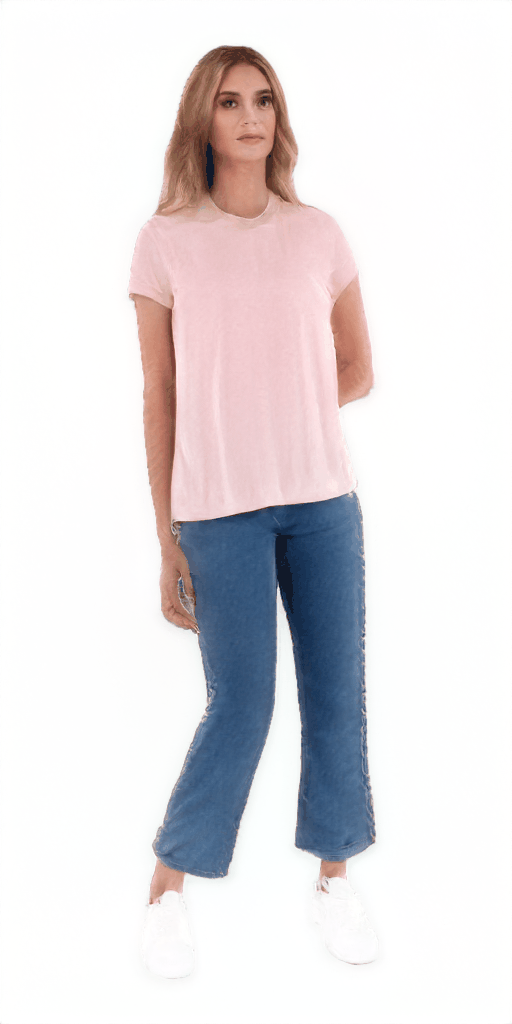

In [449]:
display_gif(rec_1_path)

In [450]:
with torch.no_grad():
    rec_1_path = f'{save_dir}/find_tuned_rec.gif'
#     src_feat = model.clip_encode_text("A photo of a woman wearing tshirt with short sleeves")  # - model.clip_encode_text([src_desc])
#     tgt_feat = model.clip_encode_text("A photo of a woman wearing tshirt with long sleeves")  # - model.clip_encode_text([src_desc])
    
    W_c_ind = 1 #len(b1) // 2
    W_c = b1[W_c_ind:W_c_ind+1]
    ref_frame = model.stylegan_G(W_c)
    ref_frame_enc =  model.clip_loss.encode_images(ref_frame)
    rec_vid_1 = model(a1.unsqueeze(0), 
                                  c1,
                                  W_c,
                                  torch.zeros_like(txt_feat_1),
                                 ref_frame_enc)[0]
    save_gif(rec_vid_1, (-1, 1), rec_1_path)

/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


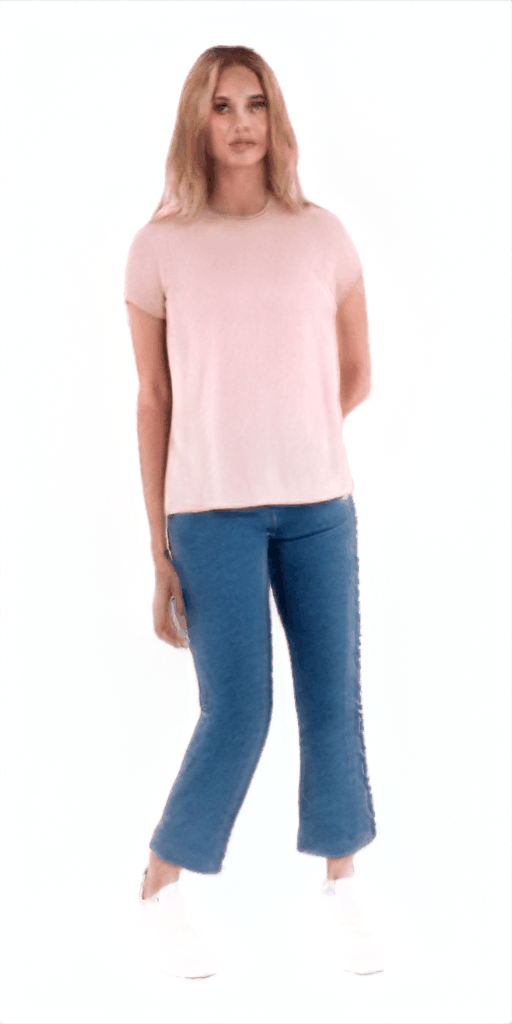

In [451]:
display_gif(rec_1_path)

In [452]:
with torch.no_grad():
    rec_1_path = f'{save_dir}/find_tuned_manipulalted.gif'
    src_feat = model.clip_encode_text("A photo of a woman wearing short sleeves tshirt")  # - model.clip_encode_text([src_desc])
    tgt_feat = model.clip_encode_text("A photo of a woman wearing long sleeves tshirt")  # - model.clip_encode_text([src_desc])
    
    W_c_ind = len(b1) // 2
    W_c = b1[W_c_ind:W_c_ind+1]
    ref_frame = model.stylegan_G(W_c)
    ref_frame_enc =  model.clip_loss.encode_images(ref_frame)
    rec_vid_1 = model(a1.unsqueeze(0), 
                                  c1,
                                  W_c,
                                  (tgt_feat - src_feat) * 2.0,
                                 ref_frame_enc)[0]
    save_gif(rec_vid_1, (-1, 1), rec_1_path)

/kuacc/users/mali18/.conda/envs/styleode/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


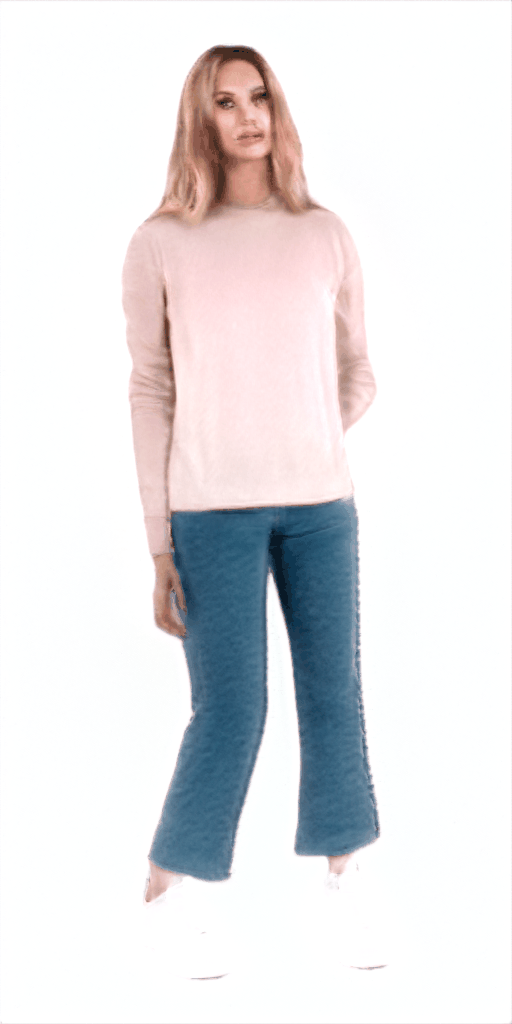

In [453]:
display_gif(rec_1_path)

In [347]:
def save_tuned_G(generator, save_path):
    generator = copy.deepcopy(generator).cpu()
    torch.save({'generator': generator}, save_path)

In [323]:
if save_ckpt: 
    save_tuned_G(model.stylegan_G.G, f"{save_dir}/fined_tuned.pt")